In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt


In [2]:
# Kontrollera kodningen vid inläsning av data
path = "./data/age_gender/UTKFace"
files = os.listdir(path)

images = []
ages = []
genders = []

for file in files:
    image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (64, 64))
    image = image.reshape((64, 64, 1))
    images.append(image)
    
    # Extrahera ålder och kön från filnamnet
    age, gender = int(file.split('_')[0]), int(file.split('_')[1])
    ages.append(age)
    genders.append(gender)

# Konvertera listorna till numpy-arrayer
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

# Kontrollera att könsetiketterna är korrekt kodade
print("Exempel på könsetiketter:", genders[:10])  # Visa de första 10 könsetiketterna


Exempel på könsetiketter: [0 0 1 1 1 1 1 1 1 1]


In [3]:
# Dela data i tränings- och valideringsuppsättningar
X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42
)

# Kombinera ålder och kön i en enda numpy-array
y_train_combined = np.column_stack((y_age_train, y_gender_train))
y_val_combined = np.column_stack((y_age_val, y_gender_val))

print(f"Form på y_train_combined: {y_train_combined.shape}")


Form på y_train_combined: (18966, 2)


In [4]:
def custom_generator(data, labels, batch_size):
    while True:
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        for i in range(0, len(data), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_data = data[batch_indices]
            batch_labels = labels[batch_indices]
            yield batch_data, {'age_output': batch_labels[:, 0], 'gender_output': batch_labels[:, 1]}


In [5]:
batch_size = 32

# Skapa generatorer för tränings- och valideringsdata
train_generator = custom_generator(X_train, y_train_combined, batch_size=batch_size)
validation_generator = custom_generator(X_val, y_val_combined, batch_size=batch_size)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 592
Validation steps: 148


In [6]:
# Bygg en modell med separata utgångar för ålder och kön
input_layer = Input(shape=(64, 64, 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

age_output = Dense(1, name='age_output')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Kompilera modellen
model.compile(optimizer='adam', 
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'}, 
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

# Kontrollera modellens sammanfattning
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30752)     │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │     30,753 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │     30,753 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,826 (241.51 KB)

 Trainable params: 61,826 (241.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Justerad EarlyStopping
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min',
    restore_best_weights=True
)


In [8]:
# Träna modellen med den justerade EarlyStopping och generatorer
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopper],
    verbose=1
)


Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - age_output_mae: 37.4939 - gender_output_accuracy: 0.6867 - loss: 5808.1743 - val_age_output_mae: 10.9217 - val_gender_output_accuracy: 0.8283 - val_loss: 196.1476
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - age_output_mae: 10.8669 - gender_output_accuracy: 0.8151 - loss: 199.4399 - val_age_output_mae: 10.1093 - val_gender_output_accuracy: 0.8034 - val_loss: 177.9860
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - age_output_mae: 9.9503 - gender_output_accuracy: 0.8431 - loss: 169.4976 - val_age_output_mae: 10.9065 - val_gender_output_accuracy: 0.8206 - val_loss: 204.6591
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - age_output_mae: 9.5504 - gender_output_accuracy: 0.8675 - loss: 153.5723 - val_age_output_mae: 10.6112 - val_gender_output_accuracy: 0.8352 - val_loss: 196.4794
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - age_output_mae: 9.3371 - gender_output_accuracy: 0.8744 - loss: 145.9152 - val_age_

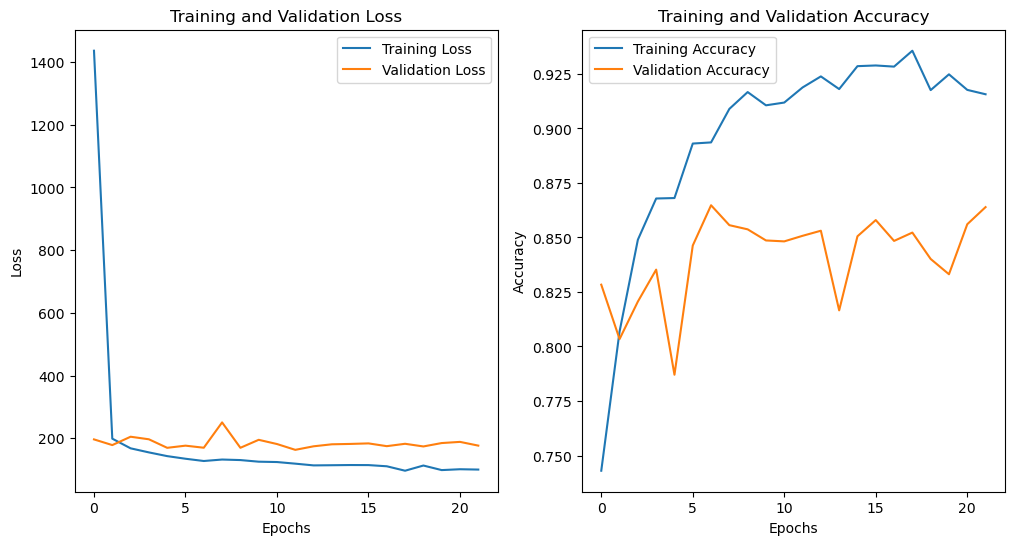

In [9]:
# Visualisera tränings- och valideringsförlust och noggrannhet
plt.figure(figsize=(12, 6))

# Förlust
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Noggrannhet
plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [10]:
# Utvärdera modellen på träningsdata
train_loss, train_age_mae, train_gender_accuracy = model.evaluate(train_generator, steps=steps_per_epoch)
print(f"Träning - Förlust: {train_loss}, Ålder MAE: {train_age_mae}, Kön Noggrannhet: {train_gender_accuracy}")

# Utvärdera modellen på valideringsdata
val_loss, val_age_mae, val_gender_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Validering - Förlust: {val_loss}, Ålder MAE: {val_age_mae}, Kön Noggrannhet: {val_gender_accuracy}")


592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_mae: 7.2572 - gender_output_accuracy: 0.9434 - loss: 91.1880
Träning - Förlust: 90.49185943603516, Ålder MAE: 7.276617050170898, Kön Noggrannhet: 0.9443857669830322
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - age_output_mae: 9.7403 - gender_output_accuracy: 0.8442 - loss: 164.8936
Validering - Förlust: 162.9702606201172, Ålder MAE: 9.702815055847168, Kön Noggrannhet: 0.846921443939209


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


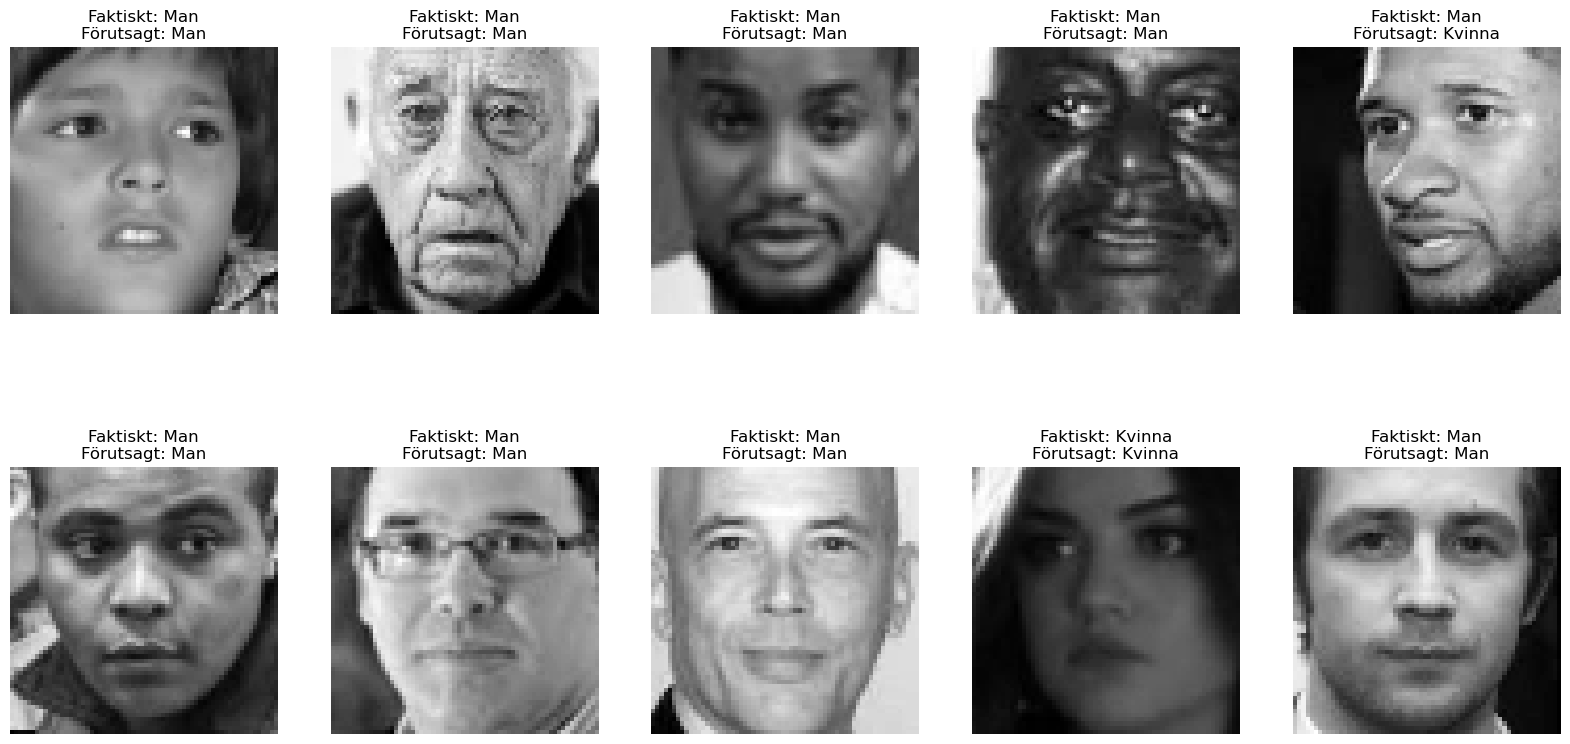

In [11]:
# Gör förutsägelser på en batch av valideringsdata
val_data_batch, val_label_batch = next(validation_generator)
age_predictions, gender_predictions = model.predict(val_data_batch)

# Tolkning av könsprediktioner
gender_predictions_interpreted = np.where(gender_predictions > 0.5, 1, 0)  # 1 = Kvinna, 0 = Man

# Visualisera de första 10 bilderna med förutsägelser
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(val_data_batch[i].reshape(64, 64), cmap='gray')
    plt.title(f"Faktiskt: {'Man' if val_label_batch['gender_output'][i] == 0 else 'Kvinna'}\n"
              f"Förutsagt: {'Man' if gender_predictions_interpreted[i] == 0 else 'Kvinna'}")
    plt.axis('off')
plt.show()


In [26]:
# Spara den tränade modellen i det nya Keras-formatet
model.save('age_gender_detection_model.keras')